In [1]:
from sensray import PlanetModel, CoordinateConverter
import numpy as np

/home/adrian/miniconda3/envs/masters/lib/python3.11/site-packages/obspy/core/util/base.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
model = PlanetModel.from_standard_model('M3')

[321.0999999999999, 1699.1, 1737.1]
1737.1


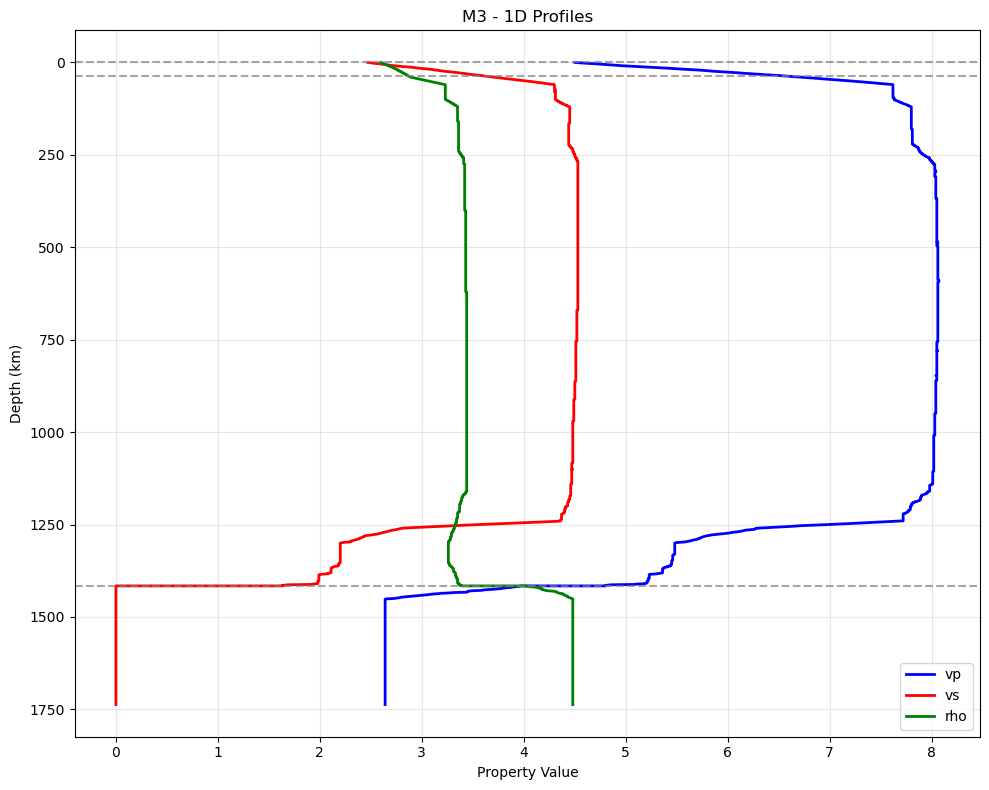

In [3]:
model.plot_profiles()
print(model.get_discontinuities())
print(model.radius)

In [4]:
# Load model and create mesh
model = PlanetModel.from_standard_model('M1')
# Create mesh and save if not exist, otherwise load existing
mesh_path = "M1_mesh"
try:
    model.create_mesh(from_file=mesh_path)
    print(f"Loaded existing mesh from {mesh_path}")
except FileNotFoundError:
    print("Creating new mesh...")
    radii = [321.1, 487.1, 1699.1, 1737.1]
    H_layers = [100, 100, 100, 100]
    model.create_mesh(mesh_size_km=1000, radii=radii, H_layers=H_layers)
    model.mesh.populate_properties(['vp', 'vs', 'rho'])
    model.mesh.save("M1_mesh")  # Save mesh to VT
print(f"Created mesh: {model.mesh.mesh.n_cells} cells")

Loaded mesh from M1_mesh.vtu
Loaded metadata: 17761 cells, 3588 points
Loaded existing mesh from M1_mesh
Created mesh: 17761 cells


In [5]:
# Define source (earthquake) and receiver (seismic station) locations
source_lat, source_lon, source_depth = 0.0, 0.0, 150.0  # Equator, 150 km depth
receiver_lat, receiver_lon = 30.0, 45.0  # Surface station

# Compute great-circle plane normal for cross-sections
plane_normal = CoordinateConverter.compute_gc_plane_normal(
    source_lat, source_lon, receiver_lat, receiver_lon
)

# Cross-section showing background Vp
print("Background P-wave velocity:")
plotter1 = model.mesh.plot_cross_section(
    plane_normal=plane_normal,
    property_name='vp',
)
plotter1.camera.position = (8000, 6000, 10000)

plotter1.show()


Background P-wave velocity:


Widget(value='<iframe src="http://localhost:45727/index.html?ui=P_0x7fddc03a7b50_0&reconnect=auto" class="pyvi…

In [6]:
def delta_vp(xyz: np.ndarray) -> np.ndarray:
    """Example perturbation function for Vp.

    Accepts coordinates in either (N, 3) or (3, N) format.
    """
    # transform to spherical coordinates
    r, theta, phi = CoordinateConverter.cartesian_to_spherical(xyz)

    # Simple spherical harmonic perturbation
    Y20 = 0.5 * np.sqrt(5 / np.pi) * (3 * np.cos(theta) ** 2 - 1)
    perturbation = 0.1 * model.get_property_at_radius(radius=r, property_name='vp') * Y20
    return perturbation

In [7]:
model.mesh.project_function_on_mesh(delta_vp, property_name='delta_vp')

In [8]:
plotter2 = model.mesh.plot_cross_section(
    plane_normal=plane_normal,
    property_name='delta_vp',
)
plotter2.camera.position = (8000, 6000, 10000)
print("Vp perturbation:")
plotter2.show()

Vp perturbation:


Widget(value='<iframe src="http://localhost:45727/index.html?ui=P_0x7fdd83f8d9d0_1&reconnect=auto" class="pyvi…